In [1]:
# load the black code formatter for jupyter lab
%load_ext lab_black

This very simple notebook will take a blood pressure reading log (the provided example data is produced by an OMRON Smart X reader), allocate the readings to three sections of the day (AM, MID and PM) and draw a boxplot to perform a first rough estimate about the presence of a trend. Then plot the measurements in time to give an idea of the trend.

Import needed libraries

In [2]:
# One ring to handle numbers
import pandas as pd
import scipy.stats as stats

# One ring to handle time
import datetime as dt
from datetime import date
import time

# One ring to draw reality
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# and One ring to rule them all ;)
# from matplotlib.dates import date2num

Set the (arbitrary) limits to divide the day in an AM, MID(day) and PM areas and the name of data file

In [3]:
AM_LIMIT = 10
PM_LIMIT = 16
LOGNAME = "data/new_bp_log.csv"
# LOGNAME = '../input/blood-pressure-readings/bp_log.csv' # on Kaggle
# https://www.kaggle.com/rjalexander/blood-pressure-circadian
systolic_thresholds = {"normal": 120, "elevated": 130, "stage1": 140, "stage2": 180}
diastolic_thresholds = {"normal": 120, "elevated": 130, "stage1": 140, "stage2": 180}

### Define some functions:

In [4]:
def classify_bp(row):
    """
    Categorize the BP level as per guidelines
    """
    if row.SYS < 120 and row.DIA < 80:
        return "normal"
    elif (row.SYS >= 120 and row.SYS <= 129) and row.DIA < 80:
        return "elevated"
    elif (row.SYS >= 130 and row.SYS <= 139) or (row.DIA >= 80 and row.DIA <= 89):
        return "stage1"
    elif (row.SYS >= 140 and row.SYS <= 179) or (row.DIA >= 90 and row.DIA <= 119):
        return "stage2"
    elif row.SYS > 180 or row.DIA > 120:
        return "crisis"

In [5]:
def partofday(hour):
    """
    generate a "partofday" categorical label based on the hour of the blood pressure reading and the limits we set above
    """
    if hour <= AM_LIMIT:
        return "AM"
    elif hour > AM_LIMIT and hour <= PM_LIMIT:
        return "MID"
    else:
        return "PM"

In [6]:
def regplot_of_df(df, barwidth):
    """
    Regression plot of SYStolic and DIAstolic values passed to it
    Each pair of reading connected by a vertical line
    Second parameter nees adjustement according to the number of X values
    """
    plt.figure(figsize=(44, 16))
    # as the scattterplot does not accept a datetime timestamp as the x values, I am using the epoch in the "elapsed_seconds" column
    ax = sns.regplot(x="unix", y="SYS", data=df, label="SYS", scatter_kws={"s": 100})
    ax = sns.regplot(x="unix", y="DIA", data=df, label="DIA", scatter_kws={"s": 100})
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    # set some other visuals
    ax.set_xlabel("Measurement Date", fontsize=28, labelpad=20)
    ax.set_ylabel("Arm cuff BP (mmHg)", fontsize=28)
    plt.legend(prop={"size": 20})
    # now add a vertical bar joining the SYS and DIA readings
    plt.bar(
        x=df["unix"],
        height=df["SYS"] - df["DIA"],
        bottom=df["DIA"],
        width=barwidth,
        color="red",
    )
    # create some whitespace horizontally around the plot values
    ax.set_xlim(df["unix"].min() - 10000, df["unix"].max() + 10000)
    # now convert the epoch values back to a YYYY-MM-DD string for the x labels
    # localtime converts the epoch into a datetime object, and strftime converts it into a string
    new_labels = [
        time.strftime("%Y-%m-%d", time.localtime(item)) for item in ax.get_xticks()
    ]
    ax.set_xticklabels(new_labels)
    plt.show()

## NOW read the CSV data and rename and add a few fields

In [7]:
df = pd.read_csv(LOGNAME)

In [8]:
# recreate a Measurement Date text field field like in the old log format to reuse older code
df["Measurement Date"] = df["Date"] + " " + df["Time"]
# also rename the systolic (SYS) and diastolic (DIA) and pulse (Pulse) columns with the old log format names
df.rename(
    columns={
        "Systolic (mmHg)": "SYS",
        "Diastolic (mmHg)": "DIA",
        "Pulse (bpm)": "Pulse",
    },
    inplace=True,
)

### Add a new "partofday" categorical new column in the dataframe

In [9]:
df["partofday"] = df.apply(
    lambda row: partofday(pd.to_datetime(row["Measurement Date"]).hour), axis=1
)

### Add a datetime column and a couple of derived ordinals


In [10]:
df["datetime"] = pd.to_datetime(
    df["Date"] + " " + df["Time"]
)  # generate a datetime object from the two Date and Time strings
df["unix"] = (
    df["datetime"].astype("int64") / 1e9
)  # generate seconds from Unix epoch from the datetime object
df["elapsed_seconds"] = (
    df["datetime"] - df["datetime"].min()
).dt.total_seconds()  # generate seconds from earliest observation time

### Also add a BP level category (normal, elevated, stage1, stage2, crisis) and show relative frequency

In [11]:
# add a BP classification (bp_class) column to the dataframe
df["bp_class"] = df.apply(classify_bp, axis=1)

### Now just drop currently unneeded columns, just for being frugal :)

In [12]:
df.drop(
    [
        "Irregular heartbeat detected",
        "Body Movement",
        "Cuff wrap guide",
        "Positioning Indicator",
        "Measurement Mode",
        "Possible Afib",
        "Device",
        "Notes",
    ],
    inplace=True,
    axis=1,
)

In [13]:
df

,Date,Time,SYS,DIA,Pulse,Measurement Date,partofday,datetime,unix,elapsed_seconds,bp_class
0,01 Jul 2022,16:59,113,76,65,01 Jul 2022 16:59,MID,2022-07-01 16:59:00,1.656695e+09,36309300.0,normal
1,01 Jul 2022,12:15,114,73,65,01 Jul 2022 12:15,MID,2022-07-01 12:15:00,1.656678e+09,36292260.0,normal
2,30 Jun 2022,19:21,118,76,62,30 Jun 2022 19:21,PM,2022-06-30 19:21:00,1.656617e+09,36231420.0,normal
3,30 Jun 2022,08:47,109,67,67,30 Jun 2022 08:47,AM,2022-06-30 08:47:00,1.656579e+09,36193380.0,normal
4,30 Jun 2022,08:23,111,73,65,30 Jun 2022 08:23,AM,2022-06-30 08:23:00,1.656577e+09,36191940.0,normal
...,...,...,...,...,...,...,...,...,...,...,...
84,30 Aug 2021,12:30,119,77,68,30 Aug 2021 12:30,MID,2021-08-30 12:30:00,1.630327e+09,9941160.0,normal
85,30 Aug 2021,16:32,127,74,80,30 Aug 2021 16:32,MID,2021-08-30 16:32:00,1.630341e+09,9955680.0,elevated
86,31 Aug 2021,08:36,127,74,65,31 Aug 2021 08:36,AM,2021-08-31 08:36:00,1.630399e+09,10013520.0,elevated
87,13 Sep 2021,10:24,130,81,71,13 Sep 2021 10:24,AM,2021-09-13 10:24:00,1.631529e+09,11143200.0,stage1


### Show how many of the readings are in each BP class

In [14]:
# count how many ocurrences of each BP reading per BP class
bp_cat_freq = df["bp_class"].value_counts()

In [15]:
bp_cat_freq

normal      40
stage1      34
elevated    15
Name: bp_class, dtype: int64

<AxesSubplot:>

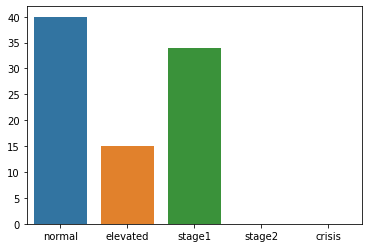

In [16]:
# reindex the data
plot_data = bp_cat_freq.reindex(["normal", "elevated", "stage1", "stage2", "crisis"])
sns.barplot(x=plot_data.index, y=plot_data.values)

### Now plot the SYS(tolic) and then the DIA(stolic) pressure values divided in the three sections of the day

In [17]:
sns.set_theme(style="whitegrid")

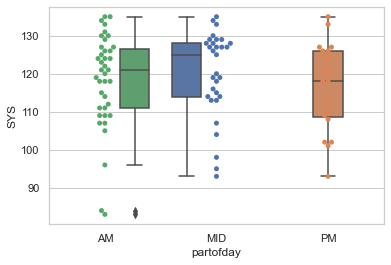

In [18]:
ax = sns.boxplot(
    x=df["partofday"],
    y=df["SYS"],
    hue=df["partofday"],
    data=df,
    order=["AM", "MID", "PM"],
)
ax = sns.swarmplot(
    x=df["partofday"],
    y=df["SYS"],
    hue=df["partofday"],
    data=df,
    order=["AM", "MID", "PM"],
)
ax.legend_.remove()

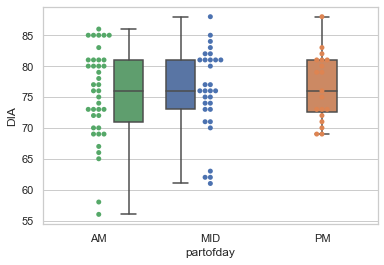

In [19]:
ax = sns.boxplot(
    x=df["partofday"],
    y=df["DIA"],
    hue=df["partofday"],
    data=df,
    order=["AM", "MID", "PM"],
)
ax = sns.swarmplot(
    x=df["partofday"],
    y=df["DIA"],
    hue=df["partofday"],
    data=df,
    order=["AM", "MID", "PM"],
)
ax.legend_.remove()

### Now let's perform a t-test to see if there's a statistically significant difference in the average BP between AM and PM

In [20]:
stats.ttest_ind(df["SYS"][df["partofday"] == "AM"], df["SYS"][df["partofday"] == "PM"])

Ttest_indResult(statistic=0.5225151271488987, pvalue=0.6033728072904115)

In [21]:
stats.ttest_ind(df["DIA"][df["partofday"] == "AM"], df["DIA"][df["partofday"] == "PM"])

Ttest_indResult(statistic=-0.5618151569502602, pvalue=0.576483733567696)

Now let's perform a t-test to see if there's a statistically significant difference in the average BP between AM and MIDday

In [22]:
stats.ttest_ind(df["SYS"][df["partofday"] == "AM"], df["SYS"][df["partofday"] == "MID"])

Ttest_indResult(statistic=-0.6071602161410863, pvalue=0.5457667050073587)

In [23]:
stats.ttest_ind(df["DIA"][df["partofday"] == "AM"], df["DIA"][df["partofday"] == "MID"])

Ttest_indResult(statistic=-0.18894306852713616, pvalue=0.8507002322343199)

#### Conclusion: no significant distribution variability of blood presure values between the three daily phases 

### Let's now plot the BP values and see what's their temporal trend in time

/var/folders/gr/jz04bv8x6sx3t0dx_m_6x72m0000gn/T/ipykernel_22219/3159274245.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels)


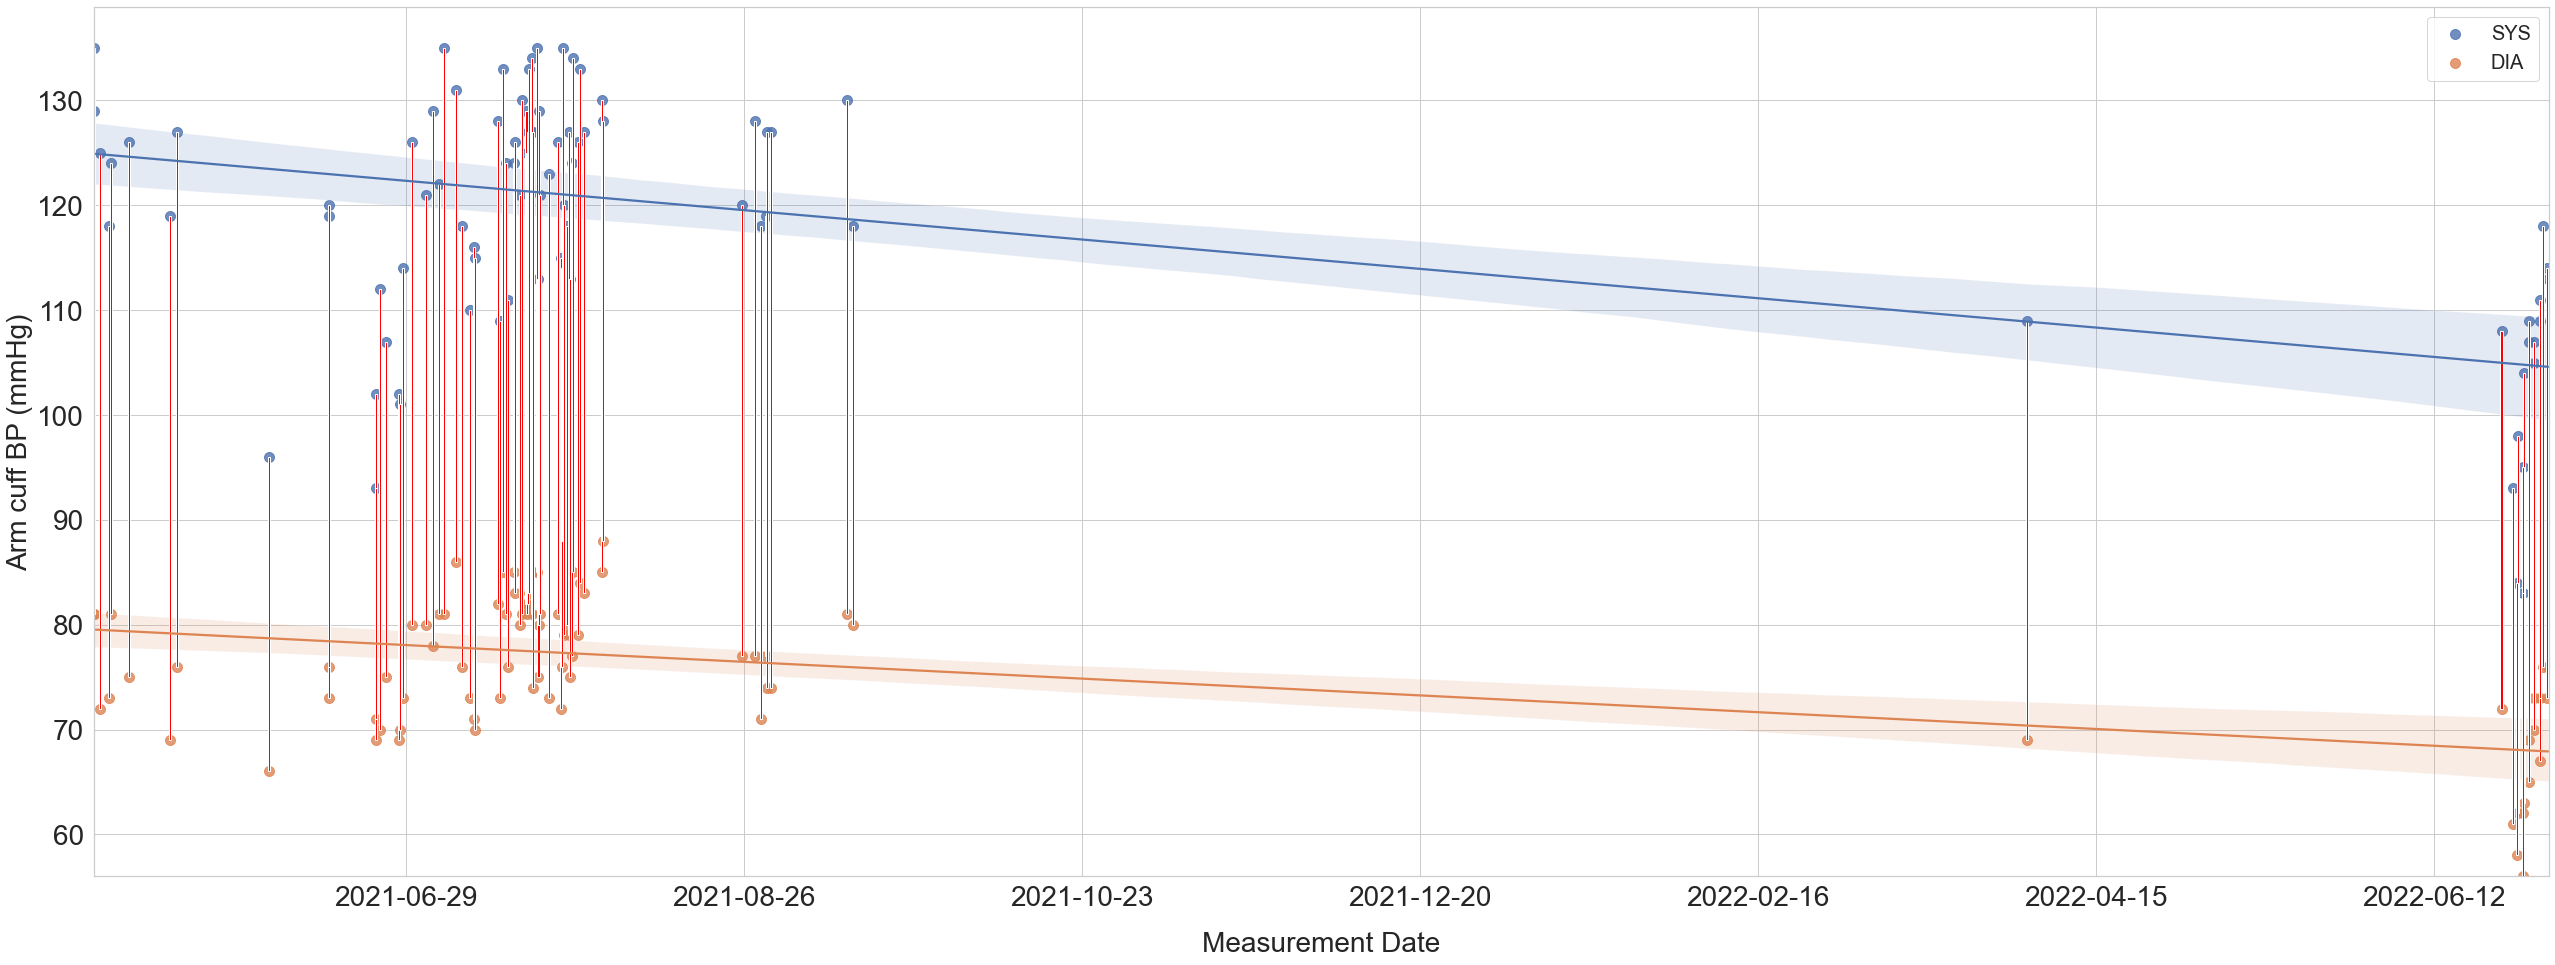

In [24]:
regplot_of_df(df, 30000)

### Extract the data subset for last week and last 30 days measurments

In [25]:
today = date.today()
week_prior = today - dt.timedelta(weeks=1)
month_prior = today - dt.timedelta(days=30)
df_lastweek = df[df["datetime"].dt.date >= week_prior]
df_lastmonth = df[df["datetime"].dt.date >= month_prior]

# Now describe last week measurements if available

In [26]:
df_lastweek.describe()

,SYS,DIA,Pulse,unix,elapsed_seconds
count,15.000000,15.000000,15.000000,1.500000e+01,1.500000e+01
mean,103.333333,66.933333,67.600000,1.656439e+09,3.605350e+07
std,10.580755,6.496886,3.042555,1.662791e+05,1.662791e+05
min,83.000000,56.000000,62.000000,1.656172e+09,3.578694e+07
25%,96.500000,62.000000,65.000000,1.656327e+09,3.594171e+07
50%,107.000000,67.000000,67.000000,1.656411e+09,3.602508e+07
75%,110.000000,73.000000,69.500000,1.656578e+09,3.619266e+07
max,118.000000,76.000000,73.000000,1.656695e+09,3.630930e+07


/var/folders/gr/jz04bv8x6sx3t0dx_m_6x72m0000gn/T/ipykernel_22219/3159274245.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels)


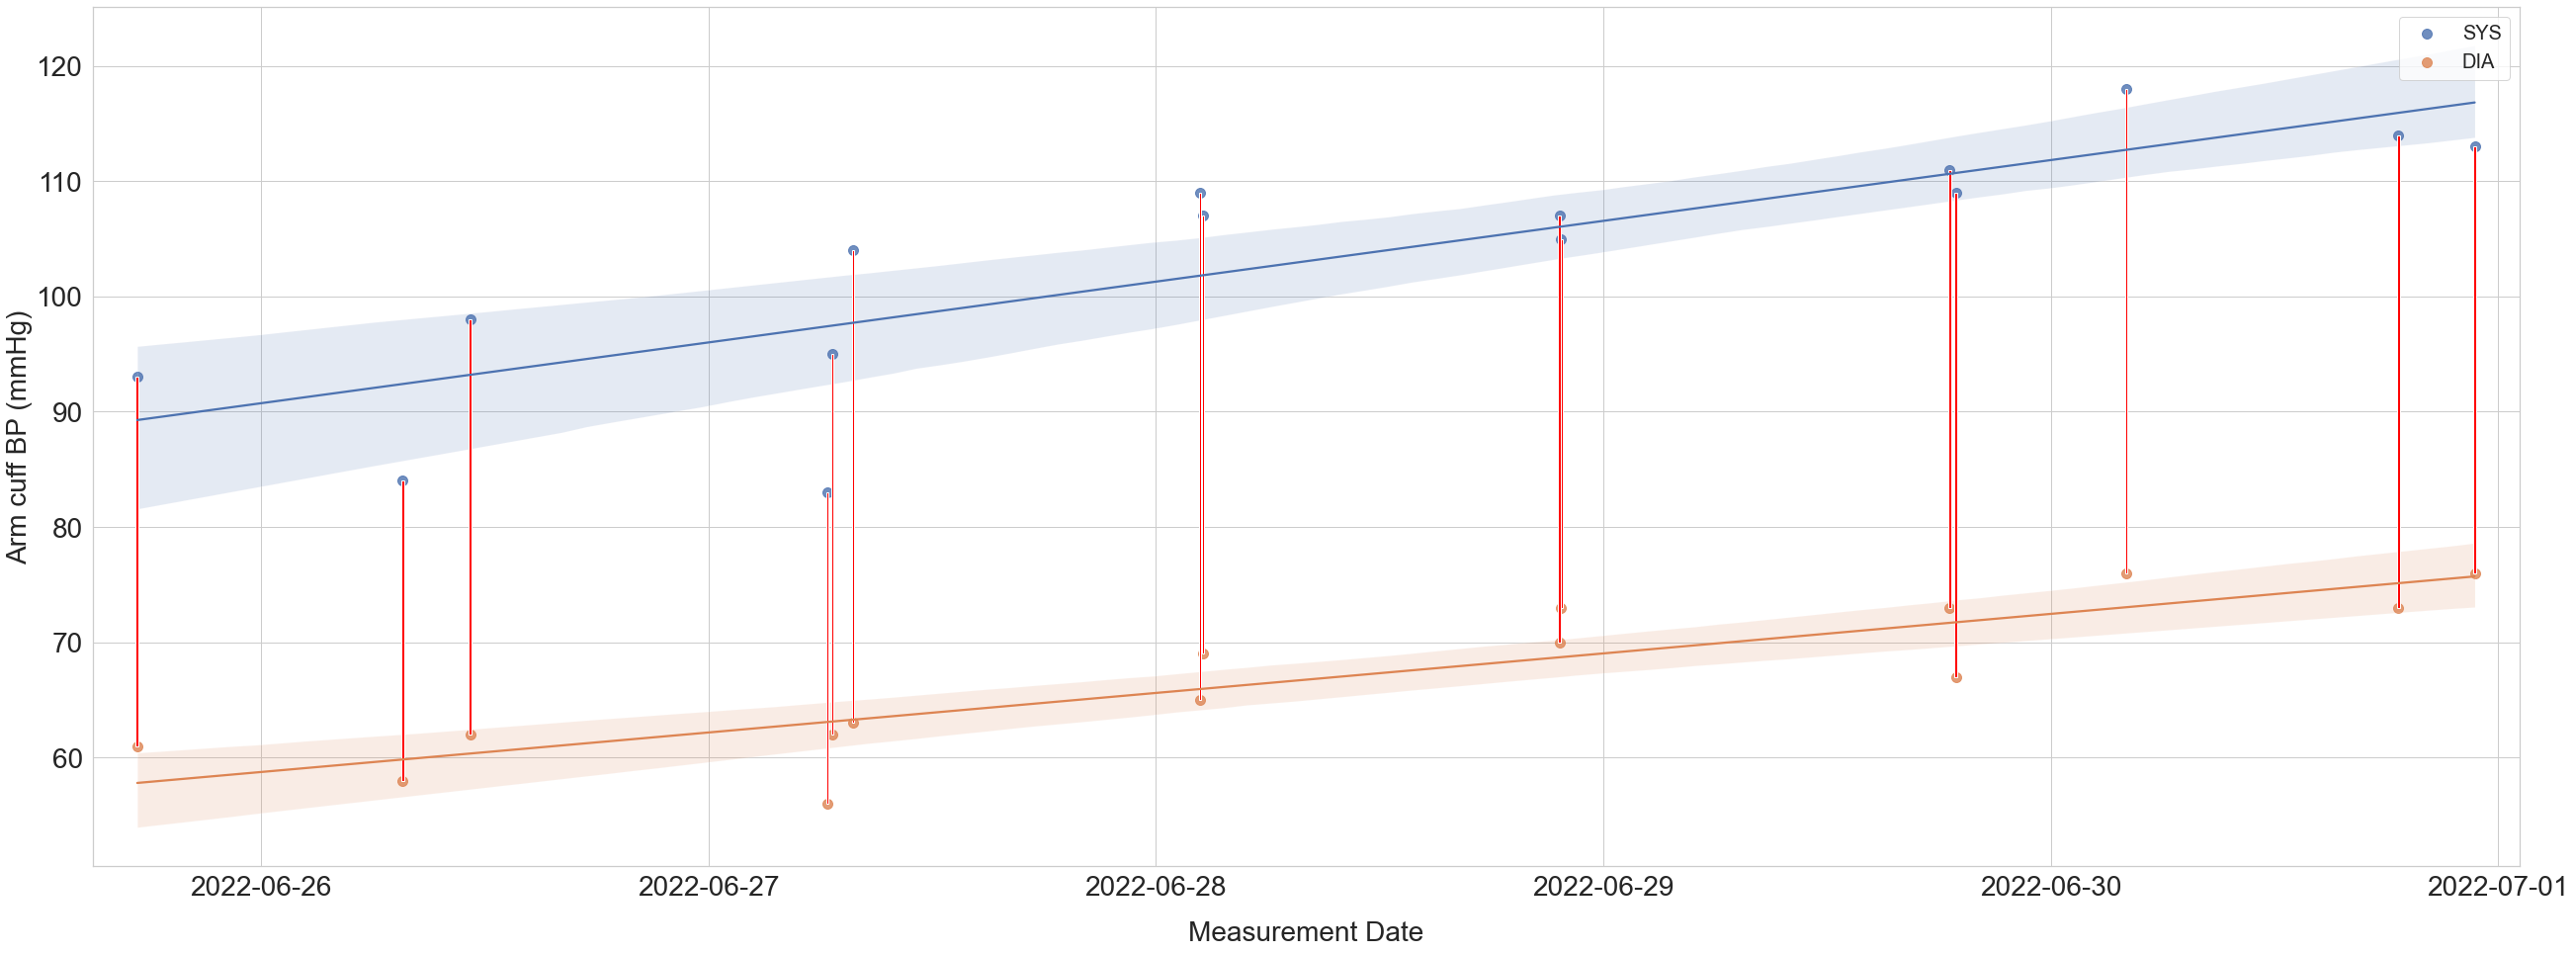

In [31]:
regplot_of_df(df_lastweek, 600)

# Now describe last 30 days measurements and plot them (if different from last week)

In [28]:
df_lastmonth.describe()  #### to be remove when the following statement will work

,SYS,DIA,Pulse,unix,elapsed_seconds
count,16.000000,16.000000,16.000000,1.600000e+01,1.600000e+01
mean,103.625000,67.250000,67.562500,1.656412e+09,3.602641e+07
std,10.288343,6.403124,2.943213,1.937860e+05,1.937860e+05
min,83.000000,56.000000,62.000000,1.656005e+09,3.561996e+07
25%,97.250000,62.000000,65.000000,1.656307e+09,3.592119e+07
50%,107.000000,68.000000,67.000000,1.656410e+09,3.602475e+07
75%,109.500000,73.000000,69.250000,1.656578e+09,3.619230e+07
max,118.000000,76.000000,73.000000,1.656695e+09,3.630930e+07


/var/folders/gr/jz04bv8x6sx3t0dx_m_6x72m0000gn/T/ipykernel_22219/3159274245.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels)


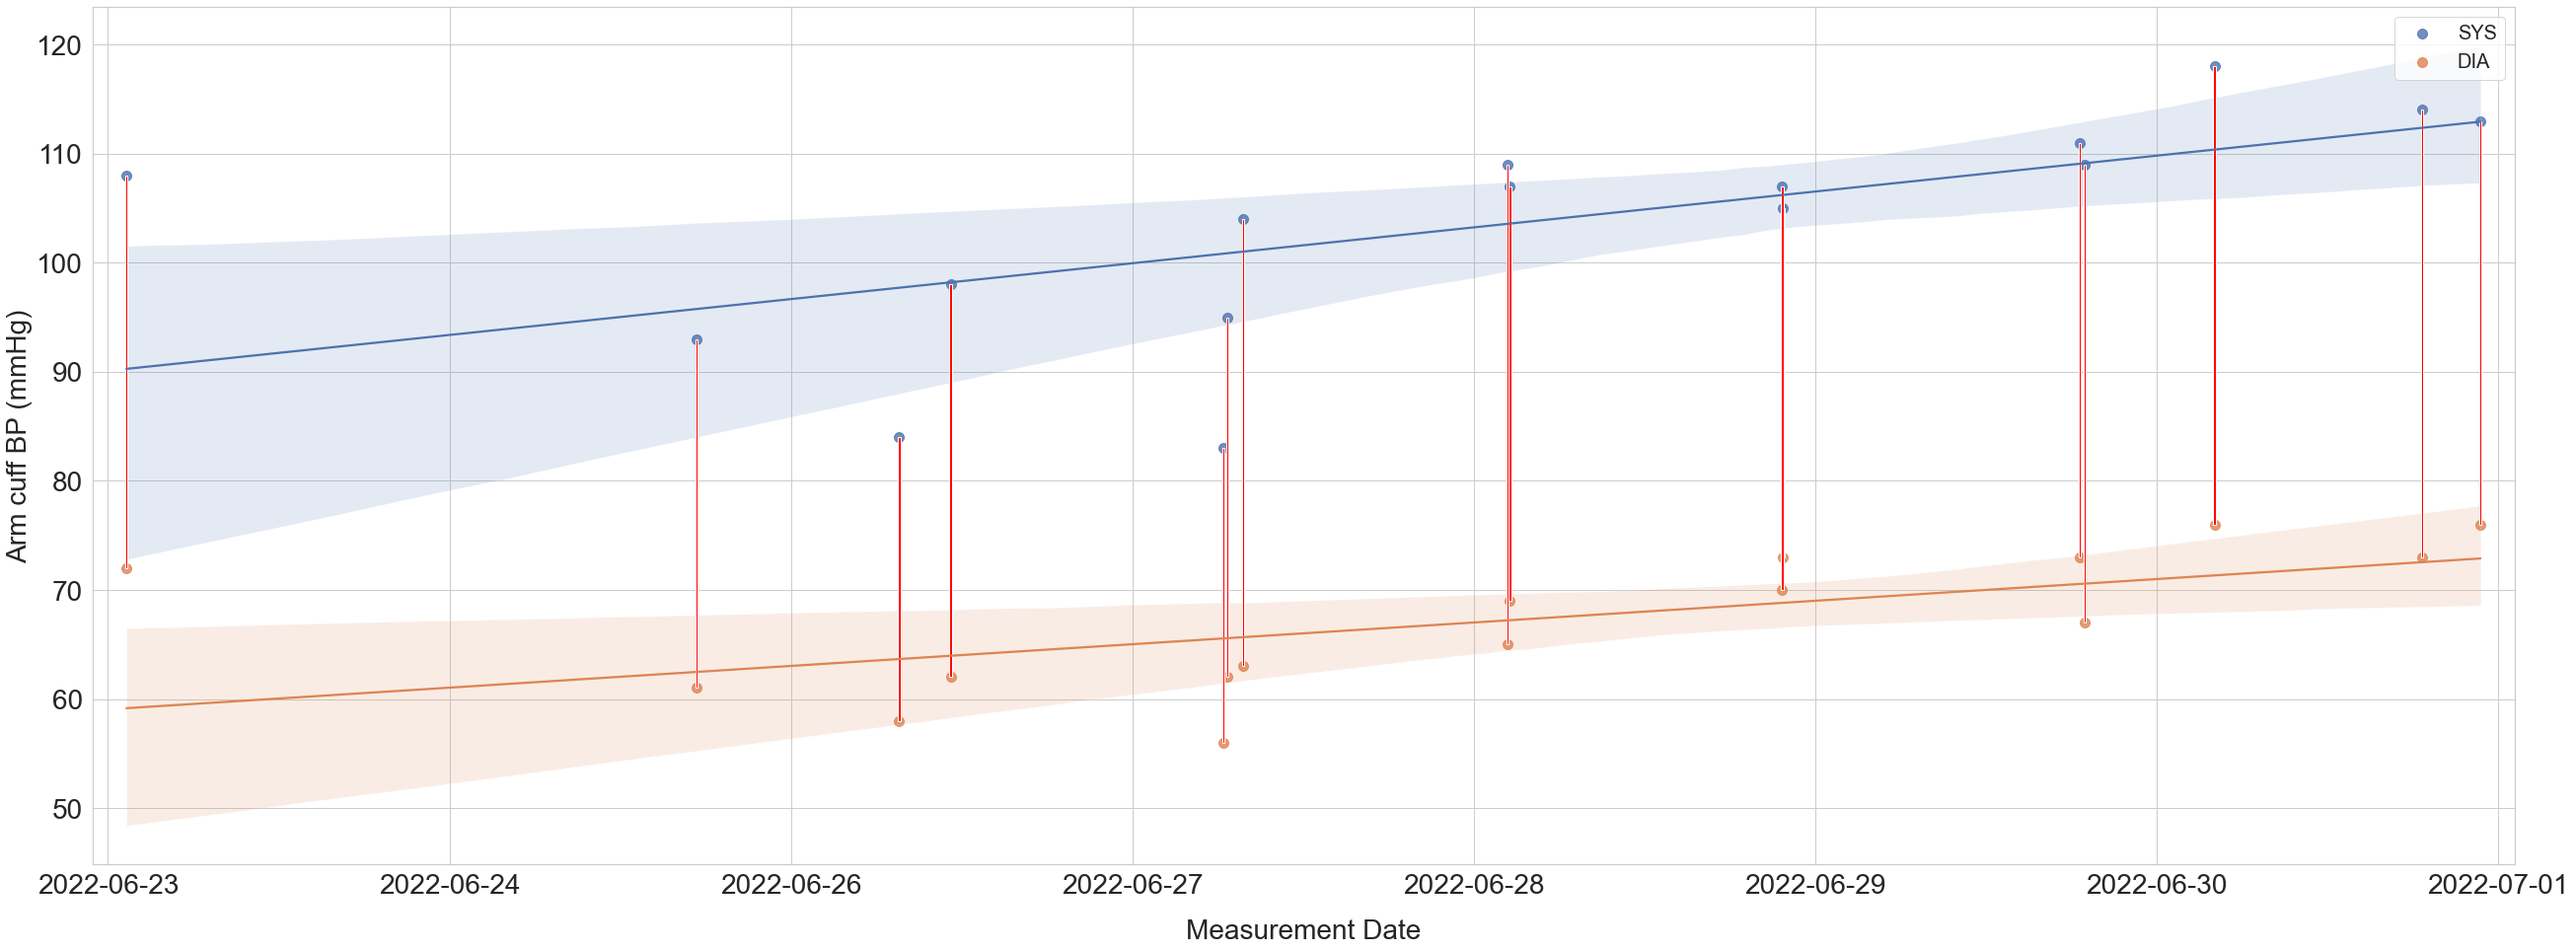

In [29]:
if not df_lastweek.equals(df_lastmonth):
    regplot_of_df(df_lastmonth, 700)